In [1]:
from PIL import Image #with image we create image objects
import matplotlib.pyplot as plt #we use matplotlib to dispay images
import numpy as np

import sys
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
from scipy.signal import convolve2d

from tqdm import trange

 # Reading

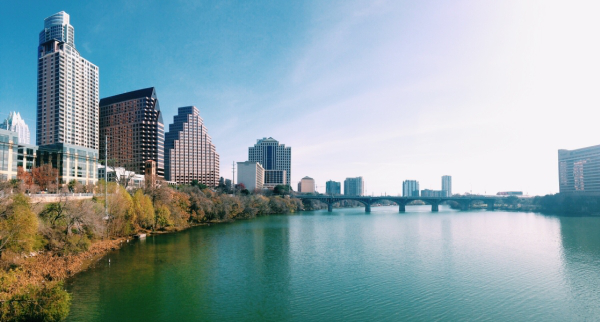

In [2]:
image= Image.open('austin.jpg')
image

#  Displaying

In [3]:
image.show() #opens default photo viewer in pc

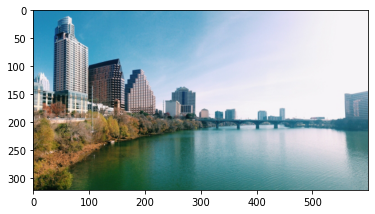

In [30]:
plt.imshow(image) #displays it in python

#  Properties of image

In [4]:
print(image.size) #we have 600 width and 322 height
print(image.format)
print(image.mode) 
# we can save an image by image.save('photo.jpg')

(600, 322)
JPEG
RGB


 # Convert to numpy format

In [3]:
data=np.array(image)
data.shape

(322, 600, 3)

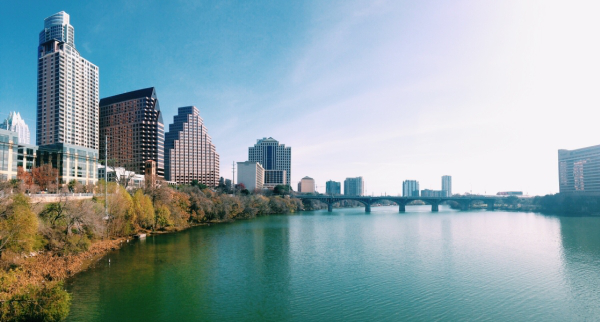

In [7]:
#the other way, the riverse:
num_image=Image.fromarray(data)
num_image

   # Energy calculation

In [4]:
#way1
def calc_energy(img):
    #compute the derivatives of the image with using convolution filter, sobel operator
    dx=np.array([[-1,-2,-1],[0,0,0],[1,2,1]]) #vertical filter
    dy=np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) #horizontal filter
    dx= np.stack([dx]*3, axis=2)
    dy= np.stack([dy]*3, axis=2)
    img = img.astype('float32')
    conv = np.add(np.absolute(convolve(img, dx)), np.absolute(convolve(img, dy)))
    energy = conv.sum(axis=2)
    return energy

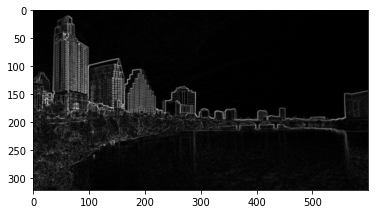

In [5]:
energy=calc_energy(data)
plt.imshow(energy, cmap='gray')

# Way 2 for sobel filter

In [125]:
#way2 for sobel filter
def compute_energy(img):
    x=np.array([[-1,-2,-1],[0,0,0],[1,2,1]]) #sobel x, for horizontal edges
    y=np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) #sobel y, for vertical edges
    gaussian=np.array([[1,2,1],[2,4,2],[1,2,1]]) *(1/16) #gaussian filter for blouring the image

    img=image.convert('L') #convert the image to grayscale 
    blurred = convolve2d(img, gaussian, mode='same', boundary='symm')

    # and now apply the sobel filter to find the derivatives vertical and horizontal

    dx=convolve2d(blurred, x, mode='same', boundary='symm')
    dy=convolve2d(blurred,y , mode='same', boundary='symm')
    #we want the total energy map
    energy_map= np.sqrt(dx*dx + dy*dy)
    energy_map = energy_map * (255.0 / np.max(energy_map))
    return energy_map

# Different filters for energy calculation

In [16]:
from skimage import filters
data=image.convert('L')
energyrob = filters.roberts(data)
energysch = filters.scharr(data)
energypre = filters.prewitt(data)

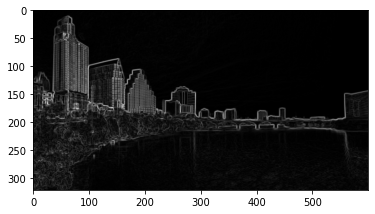

In [21]:
plt.imshow(energyrob, cmap='gray')

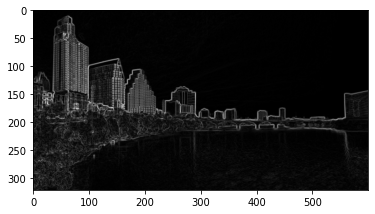

In [22]:
plt.imshow(energysch, cmap='gray')

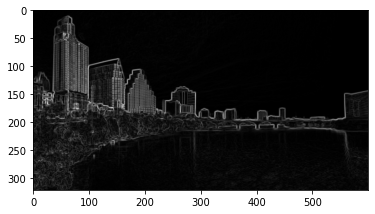

In [25]:
plt.imshow(energypre, cmap='gray')

In [124]:
k=compute_energy(data)
k.shape
plt.imshow(k, cmap='gray')

(322, 600)

# Find the seam with least energy

In [54]:
 r, c, _ = data.shape

In [33]:
data.shape

(322, 600, 3)

In [5]:
def minimum_seam(data):
    rows, cols, _ = data.shape
    energy_map = calc_energy(data)

    M = energy_map.copy() 
    backtr = np.zeros_like(M, dtype=np.int) 

    for i in range(1, rows):
        for j in range(0, cols):
            
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtr[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtr[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtr

In [35]:
M,N =minimum_seam(data)

C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


# M(i,j) for width

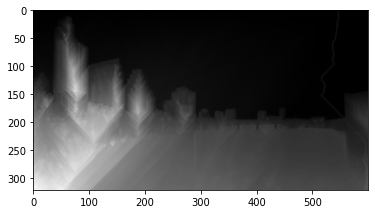

In [36]:
plt.imshow(M, cmap='gray')

# M(i,j) for height

C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


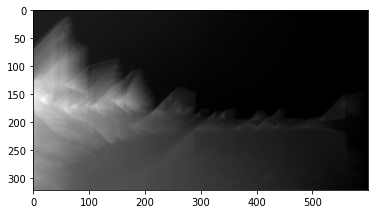

In [7]:
datahor=np.rot90(data, 1, (0, 1))
datahor.shape
m,n =minimum_seam(datahor)
mrot=np.rot90(m, 3, (0, 1))
plt.imshow(mrot, cmap='gray')

# Delete the pixels from the seam with the least energy

In [6]:
def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])
    redline= np.ones(len(mask))
    
    for i in reversed(range(r)):
        # Mark the pixels for deletion
        mask[i, j] = False
        j = backtrack[i, j]
    #uncomment the 4 lines to see the first red seam    
    #for i in range(0,r):
        #for j in range(0,c):
            #if (mask[i,j]== False):
                #img[i,j]=(255,0,0)
                
    # Since the image has 3 channels, we convert our
    # mask to 3D
    mask = np.stack([mask] * 3, axis=2)
    
    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape((r, c - 1, 3))

    return img

In [12]:
new_img = carve_column(data)

C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

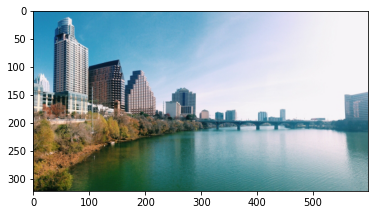

In [11]:
plt.imshow(new_img)

In [13]:
new_img.shape #599 shape

(322, 599, 3)

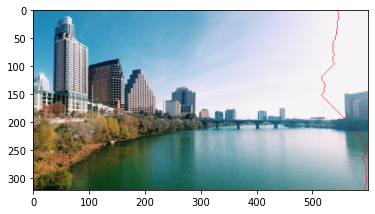

In [12]:
plt.imshow(im)

# Now restart the kernel and run again carve_column for datahor image.
(means data horizontal)

In [10]:
new_img_hor, im_hor = carve_column(datahor)

C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

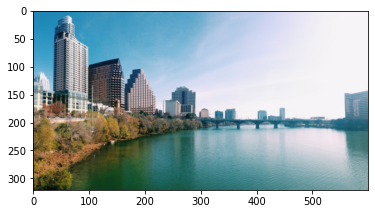

In [14]:
plt.imshow(np.rot90(new_img_hor, 3, (0, 1)))


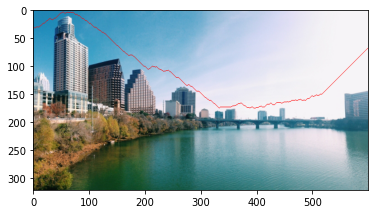

In [15]:
plt.imshow(np.rot90(im_hor, 3, (0, 1)))

In [7]:
def reduceWidth(img, num_pixels):
    r, c, _ = img.shape
    pixels= c-num_pixels
    scale_c= pixels/c
    new_c = round(scale_c * c)

    for i in trange(c - new_c): # use range if you don't want to use tqdm
        img = carve_column(img)

    return img

In [40]:
croped_width_image = reduceWidth(data,100)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

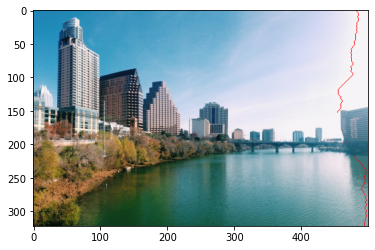

In [41]:
plt.imshow(croped_width_image)

In [14]:
croped_width_image.shape

(322, 500, 3)

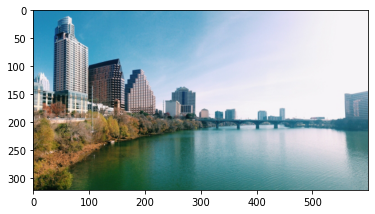

In [121]:
plt.imshow(data)

# The same for rows

In [9]:
def reduceHeight(img, num_pixels):
    img = np.rot90(img, 1, (0, 1))
    img = reduceWidth(img, num_pixels)
    #img = np.rot90(img, 3, (0, 1))
    return img

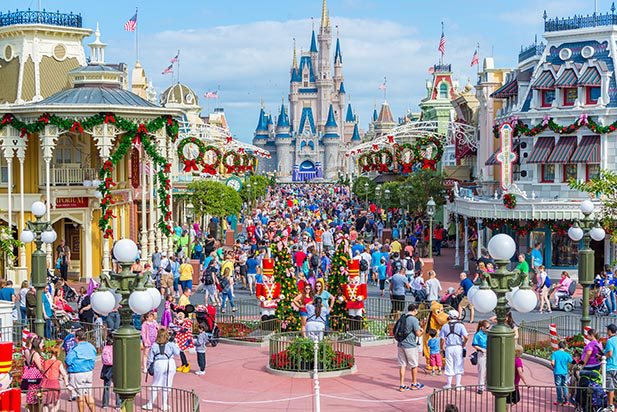

In [16]:
img2=Image.open('disney.jpg')
img2

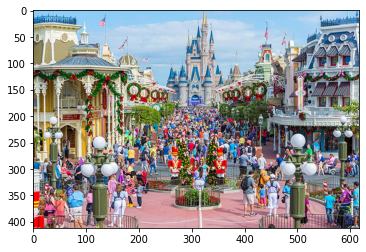

In [159]:
plt.imshow(img2)

In [17]:
data2=np.array(img2)
data2.shape

(412, 617, 3)

In [18]:
disney_cropped= reduceHeight(data2, 100)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

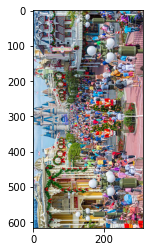

In [19]:
plt.imshow(disney_cropped)

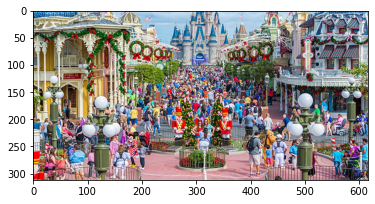

In [20]:
disney_cropped= np.rot90(disney_cropped, 3, (0, 1))
plt.imshow(disney_cropped)

In [22]:
disney_cropped.shape

(312, 617, 3)

In [27]:
data2.shape

(412, 617, 3)

# Question 5 : testing for other images

# Nature image

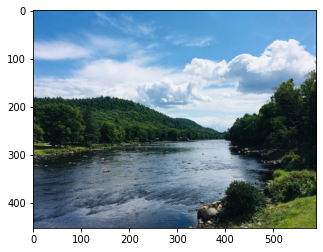

In [43]:
image= Image.open('nature.jpg')
plt.imshow(image) #displays it in python

In [44]:
data1=np.array(image)
data1.shape

(453, 590, 3)

In [46]:
nature_crop_w=reduceWidth(data1,100)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

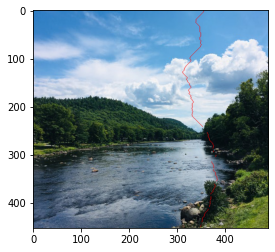

In [47]:
plt.imshow(nature_crop_w)

In [48]:
nature_crop_w.shape

(453, 490, 3)

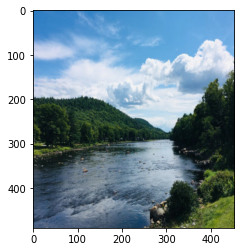

In [49]:
newsize=(453,490)
resized_image1=image.resize(newsize,Image.BILINEAR)
plt.imshow(resized_image1)

In [50]:
resized_image1.size

(453, 490)

# Zoo image - unsuccessful

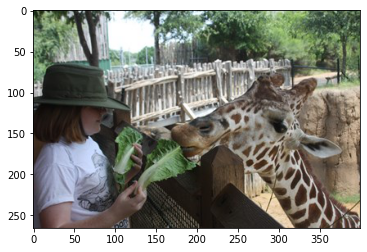

In [42]:
image= Image.open('zoo.jpg')
plt.imshow(image) #displays it in python

In [43]:
data2=np.array(image)
data2.shape

(266, 400, 3)

In [15]:
zoo_crop_w_100=reduceWidth(data2,100)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

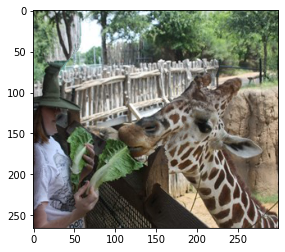

In [16]:
plt.imshow(zoo_crop_w_100)

In [18]:
zoo_crop_w_100.shape

(266, 300, 3)

In [13]:
zoo_crop_height= reduceHeight(data2,100)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

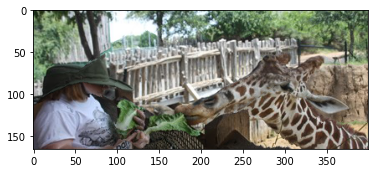

In [14]:
zoo_crop_height=np.rot90(zoo_crop_height, 3, (0, 1))
plt.imshow(zoo_crop_height)


In [17]:
zoo_crop_height.shape

(166, 400, 3)

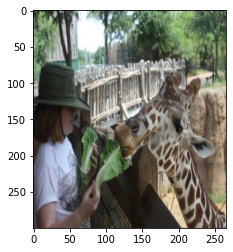

In [44]:
newsize=(266,300)
resized_image2=image.resize(newsize,Image.BILINEAR)
plt.imshow(resized_image2)

In [46]:
resized_image2.size

(266, 300)

# Portrait photo - Unsuccessful

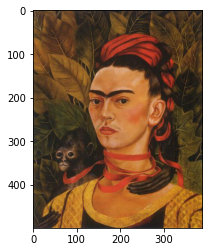

In [49]:
image= Image.open('portrait.jpg')
plt.imshow(image) #displays it in python

In [34]:
data3=np.array(image)
data3.shape

(500, 389, 3)

In [35]:
portrait_crop_height= reduceHeight(data3,100)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

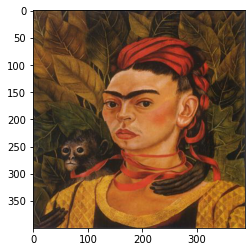

In [36]:
portrait_crop_height=np.rot90(portrait_crop_height, 3, (0, 1))
plt.imshow(portrait_crop_height)

In [55]:
portrait_crop_height.shape

(400, 389, 3)

In [38]:
portrait_crop_w_100=reduceWidth(data3,200)

  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

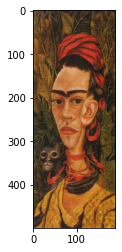

In [39]:
plt.imshow(portrait_crop_w_100)

In [47]:
portrait_crop_w_100.shape

(500, 189, 3)

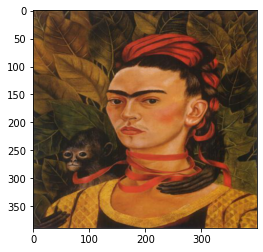

In [56]:
newsize=(400,389)
resized_image2=image.resize(newsize,Image.BILINEAR)
plt.imshow(resized_image2)

In [52]:
resized_image2.size

(500, 189)